In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12,8)

In [3]:
# Read and view data

df = pd.read_csv(r'C:\Users\canno\Documents\Lebron23\Projects\movie correlation\movies.csv')
df.head(3)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0


In [4]:
# Drop unnecessary column and zoom into more known/voted movies
# Nulls dropped here for simplicity's sake

df = df.drop(columns = 'released')
df = df.drop(df[df['votes'] < 200000].index)
df = df.drop(df[df['genre'] == 'Animation'].index)
df = df.drop(df[df['company'] == 'Marvel Studios'].index)
df = df.dropna()
df = df.reset_index(drop=True)

df.dtypes

name         object
rating       object
genre        object
year          int64
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [5]:
# Order movies by IMDb score

for i in ['votes', 'budget', 'gross', 'runtime']:
    df[i] = df[i].astype('int64')
    
df.sort_values(by=['score'], inplace=True, ascending=False)
df = df.reset_index(drop=True)

# Current dataset only shows 1 actor per movie
# To scrape more cast data from the IMDb site, we need each movie's title ID
df.insert(0, 'Title ID', "")

df.head(3)

,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,Tim Robbins,United States,25000000,28817291,Castle Rock Entertainment,142
1,,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,Christian Bale,United States,185000000,1005973645,Warner Bros.,152
2,,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,John Travolta,United States,8000000,213928762,Miramax,154


In [6]:
# Read in secondary dataset which has all IMDb movie title IDs

df2 = pd.read_csv(r'C:\Users\canno\Documents\Lebron23\Projects\movie correlation\IMDb movies.csv')
df2.head(3)

C:\Users\canno\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [7]:
# Mapping over title IDs from the secondary dataset to our primary dataframe

for movie in df['name']:
    if ((df2['original_title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])).any() == True:
        df.loc[df['name'] == movie, 'Title ID'] = df2.loc[((df2['original_title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])), 'imdb_title_id'].iloc[0]
    elif ((df2['title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])).any() == True:
        df.loc[df['name'] == movie, 'Title ID'] = df2.loc[((df2['title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])), 'imdb_title_id'].iloc[0]
    else:
        df.loc[df['name'] == movie, 'Title ID'] = np.NaN
        
df.head()

,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,tt0111161,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,Tim Robbins,United States,25000000,28817291,Castle Rock Entertainment,142
1,tt0468569,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,Christian Bale,United States,185000000,1005973645,Warner Bros.,152
2,tt0110912,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,John Travolta,United States,8000000,213928762,Miramax,154
3,tt0167260,The Lord of the Rings: The Return of the King,PG-13,Action,2003,8.9,1700000,Peter Jackson,J.R.R. Tolkien,Elijah Wood,New Zealand,94000000,1146030912,New Line Cinema,201
4,tt0108052,Schindler's List,R,Biography,1993,8.9,1200000,Steven Spielberg,Thomas Keneally,Liam Neeson,United States,22000000,322161245,Universal Pictures,195


In [8]:
# Checking how many title IDs were unable to be mapped over due to various reasons

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing*100))

Title ID - 9.07960199004975%
name - 0.0%
rating - 0.0%
genre - 0.0%
year - 0.0%
score - 0.0%
votes - 0.0%
director - 0.0%
writer - 0.0%
star - 0.0%
country - 0.0%
budget - 0.0%
gross - 0.0%
company - 0.0%
runtime - 0.0%


In [9]:
df = df.dropna()
df = df.reset_index(drop=True)
df.describe()

,year,score,votes,budget,gross,runtime
count,731.000000,731.000000,7.310000e+02,7.310000e+02,7.310000e+02,731.000000
mean,2006.227086,7.253762,4.209549e+05,7.124301e+07,3.087113e+08,122.590971
std,8.733050,0.728215,2.900551e+05,6.129217e+07,3.000778e+08,21.090824
min,1980.000000,3.800000,2.000000e+05,1.500000e+04,3.047100e+04,80.000000
25%,2001.000000,6.800000,2.440000e+05,2.500000e+07,1.071313e+08,108.000000
50%,2008.000000,7.300000,3.220000e+05,5.000000e+07,2.198512e+08,120.000000
75%,2013.000000,7.800000,4.750000e+05,1.020000e+08,4.009170e+08,134.000000
max,2020.000000,9.300000,2.400000e+06,3.170000e+08,2.847246e+09,229.000000


In [10]:
# Scraping from the IMDb website the top 5 actors of each movie

df_7up = df.loc[df['score'] >= 7] # remove this line after running

list_of_lists = []

for title_id in df_7up['Title ID']:
    stars_list = []
    url = 'https://www.imdb.com/title/{}/'.format(title_id)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    stars = soup.find_all('a', {'data-testid':'title-cast-item__actor'})[:5]
    
    for star in stars:
        stars_list.append(star.text)
        
    list_of_lists.append(stars_list)

df_7up['star'] = list_of_lists
df_7up.head()

<ipython-input-10-add46df808e0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7up['star'] = list_of_lists


,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,tt0111161,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",United States,25000000,28817291,Castle Rock Entertainment,142
1,tt0468569,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",United States,185000000,1005973645,Warner Bros.,152
2,tt0110912,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,"[John Travolta, Uma Thurman, Samuel L. Jackson...",United States,8000000,213928762,Miramax,154
3,tt0167260,The Lord of the Rings: The Return of the King,PG-13,Action,2003,8.9,1700000,Peter Jackson,J.R.R. Tolkien,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O...",New Zealand,94000000,1146030912,New Line Cinema,201
4,tt0108052,Schindler's List,R,Biography,1993,8.9,1200000,Steven Spielberg,Thomas Keneally,"[Liam Neeson, Ralph Fiennes, Ben Kingsley, Car...",United States,22000000,322161245,Universal Pictures,195


In [11]:
# Preparing each movie's actor-actor and actor-director relationships, and their occurences, into a dataframe to build our network graph
# We will be looking at relationships for movies with IMDb ratings of 7 and above

from itertools import combinations
from collections import Counter

# df_7up = df.loc[df['score'] >= 7]  (include this line after running)

edge_list = []

for row in df_7up.itertuples():
    comb = combinations(sorted(list(set([row[8]] + row[10][:3]))), 2)
    edge_list.extend(list(comb))
    
edge_df = pd.DataFrame.from_dict(Counter(edge_list), orient='index').reset_index()
edge_df[['Source', 'Target']] = pd.DataFrame(edge_df['index'].tolist(), index=edge_df.index)
edge_df.rename(columns={0:'Weight'}, inplace=True)
edge_df

,index,Weight,Source,Target
0,"(Bob Gunton, Frank Darabont)",1,Bob Gunton,Frank Darabont
1,"(Bob Gunton, Morgan Freeman)",1,Bob Gunton,Morgan Freeman
2,"(Bob Gunton, Tim Robbins)",1,Bob Gunton,Tim Robbins
3,"(Frank Darabont, Morgan Freeman)",1,Frank Darabont,Morgan Freeman
4,"(Frank Darabont, Tim Robbins)",1,Frank Darabont,Tim Robbins
...,...,...,...,...
2751,"(Bonnie Hunt, Kirsten Dunst)",1,Bonnie Hunt,Kirsten Dunst
2752,"(Bonnie Hunt, Robin Williams)",1,Bonnie Hunt,Robin Williams
2753,"(Joe Johnston, Kirsten Dunst)",1,Joe Johnston,Kirsten Dunst
2754,"(Joe Johnston, Robin Williams)",1,Joe Johnston,Robin Williams


In [12]:
# Network graph description at bottom of cell for easier referencing with graph itself

from pyvis.network import Network
import networkx as nx

directorStars_net = Network(height='1000px', width='100%', bgcolor='#222222', font_color='white', notebook=True)
directorStars_net.barnes_hut()
# directorStars_net.set_edge_smooth('curvedCW')

sources = edge_df['Source']
targets = edge_df['Target']
weights = edge_df['Weight']

edge_data = zip(sources, targets, weights)

# Add individual nodes and edges
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    directorStars_net.add_node(src, src, title=src)
    directorStars_net.add_node(dst, dst, title=dst)
    directorStars_net.add_edge(src, dst, value=w)

neighbor_map = directorStars_net.get_adj_list()

for node in directorStars_net.nodes:        
    dirEdges = []
    actEdges = []
    dirlist = []
    actlist = []
    total_weight = 0

# Add node neighbor data to node hover title    
    for edge in directorStars_net.edges:
        if edge['from'] == node['id']:
            if edge['to'] in df_7up['director'].values:
                dirEdges.append(edge)
            else:
                actEdges.append(edge)
        elif edge['to'] == node['id']:
            if edge['from'] in df_7up['director'].values:
                dirEdges.append(edge)
            else:
                actEdges.append(edge)

    dirEdges = sorted(dirEdges, key=lambda d: d['value'], reverse=True)
    actEdges = sorted(actEdges, key=lambda d: d['value'], reverse=True)

    for edge in dirEdges:
        total_weight += edge['value']
        if edge['from'] == node['id']:
            dirlist.append(edge['to'] + ' - ' + str(edge['value']))
        elif edge['to'] == node['id']:
            dirlist.append(edge['from'] + ' - ' + str(edge['value']))

    for edge in actEdges:
        total_weight += edge['value']
        if edge['from'] == node['id']:
            actlist.append(edge['to'] + ' - ' + str(edge['value']))
        elif edge['to'] == node['id']:
            actlist.append(edge['from'] + ' - ' + str(edge['value']))

    if dirlist == []:
        node['title'] += ' worked with:<br><b><u>Directors:</u></b><br>-<br><b><u>Actors:</u></b><br>' + '<br>'.join(actlist)
    else:
        node['title'] += ' worked with:<br><b><u>Directors:</u></b><br>' + '<br>'.join(dirlist) + '<br><b><u>Actors:</u></b><br>' + '<br>'.join(actlist)

# Set node shape according to role (director/actor)
    if node['id'] in df_7up['director'].values:
        node['shape'] = 'triangle'
        node['borderWidth'] = 1

# Set node color according to star value (no. of connections + weight of connections (weighted))        
    node['value'] = len(neighbor_map[node['id']])/2 + total_weight/2
    if node['value'] >= 15:
        node['color'] = '#FFA500'
        node['shape'] = 'star'
        node['borderWidth'] = 1
    elif 10 <= node['value'] < 15:
        node['color'] = '#FFA07A'

# Set edge color according to edge value
for edge in directorStars_net.edges:
    if edge['value'] == 1:
        edge['color'] = '#4682B4'
    elif edge['value'] == 2:
        edge['color'] = '#FF0000'
    elif edge['value'] == 3:
        edge['color'] = '#FF8C00'
    elif edge['value'] == 4:
        edge['color'] = '#FFD700'
    else:
        edge['color'] = '#FF00FF'
    

directorStars_net.show('stars.html')


# This interactive network graph displays associations between directors and actors from 1986-2016 of films during that period with IMDb rating scores of 7 and above

# - Hover over nodes to view association data
# - Zoom/drag to explore network and view node labels
# - Click/drag nodes to highlight edges and isolate nodes

# NODES - Represents a director or actor
    
#     "Star value" = AVERAGE between no. of unique individuals that director/actor worked with, and total no. of times director/actor has worked with others
    
#     Shape:
#         - Triangle -> director
#         - Circle   -> actor
#         - Star     -> director/actor with star value of 15 and above
        
#     Size:
#         - Scaled by star value
    
#     Color:
#         - Orange -> star value of 15 and above
#         - Salmon -> star value of 10-14
#         - Blue   -> star value of 9 and below
        
# EDGES - Represents collaboration between 2 nodes
    
#     Color:
#         - Pink -> at least 5 collaborations
#         - Yellow -> 4
#         - Orange -> 3
#         - Red -> 2
#         - Blue -> 1
    
#     Width:
#         - Scaled by no. of collaborations

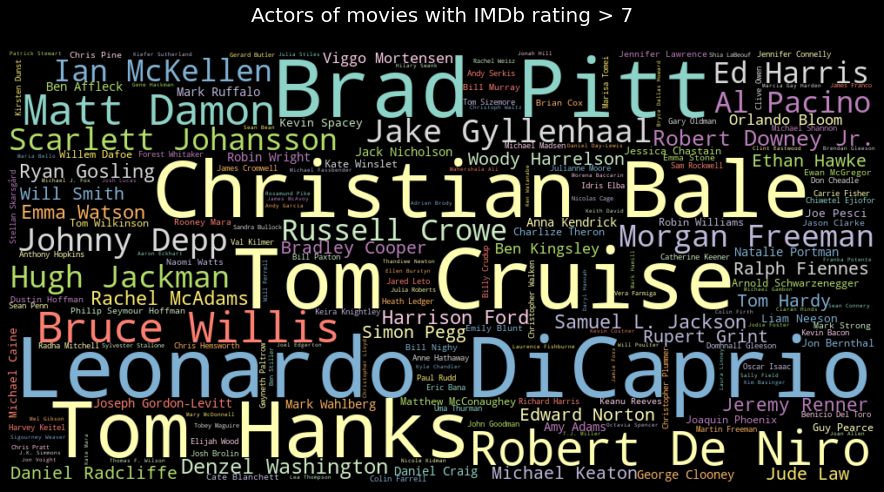

In [15]:
temp_list = []
for row in df_7up.star:
    for name in row:
        temp_list.append(name)

actor_text = Counter(temp_list)

wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='Set3').generate_from_frequencies(actor_text)

plt.figure(figsize=(16,8), facecolor='black')
plt.title('Actors of movies with IMDb rating > 7\n', {'color':'white', 'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

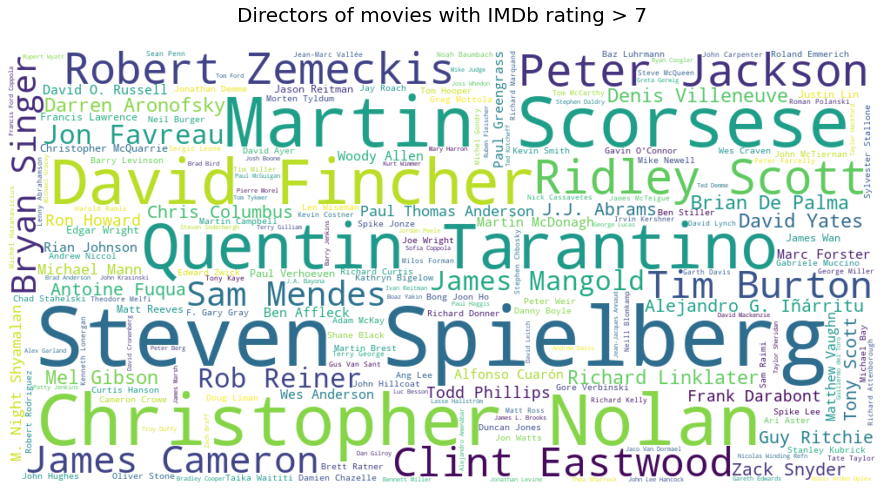

In [14]:
text = Counter(df_7up.director)

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate_from_frequencies(text)

plt.figure(figsize=(16,8))
plt.title('Directors of movies with IMDb rating > 7\n', {'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[Text(0.5, 1.0, 'Budget vs Gross Revenue')]

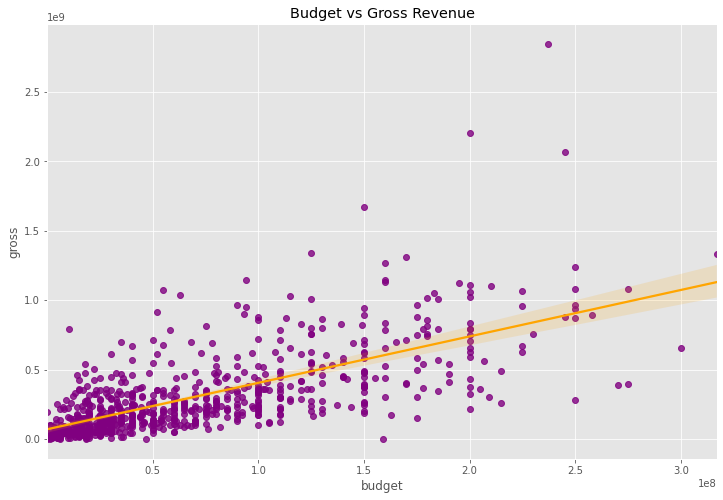

In [16]:
sns.regplot(data=df, x='budget', y='gross', scatter_kws={'color':'purple'}, line_kws={'color':'orange'}).set(title='Budget vs Gross Revenue')

[Text(0.5, 1.0, 'Score vs Gross Revenue')]

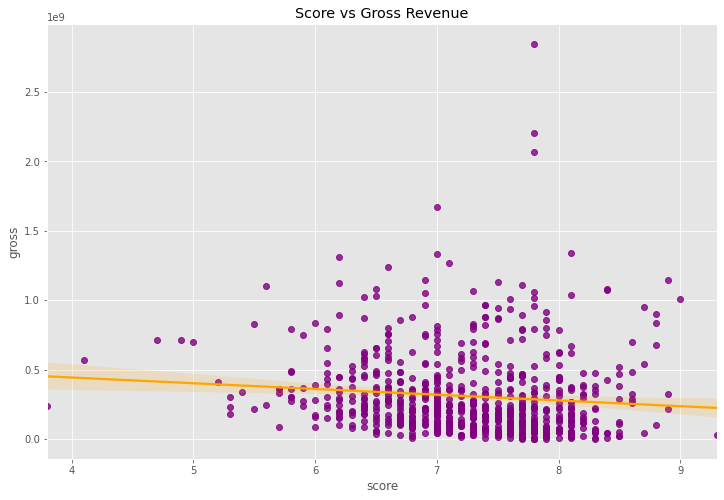

In [17]:
sns.regplot(data=df, x='score', y='gross', scatter_kws={'color':'purple'}, line_kws={'color':'orange'}).set(title='Score vs Gross Revenue')

C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'Gross Revenue by Genre')]

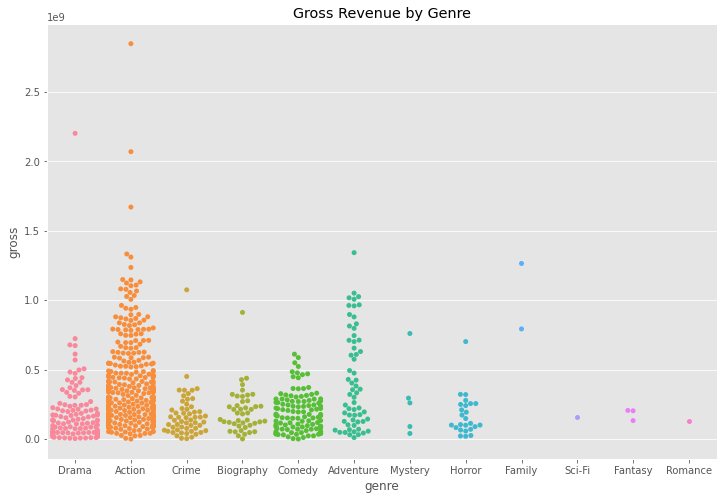

In [18]:
sns.swarmplot(x='genre', y='gross', data=df).set(title='Gross Revenue by Genre')

C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'Score by Genre')]

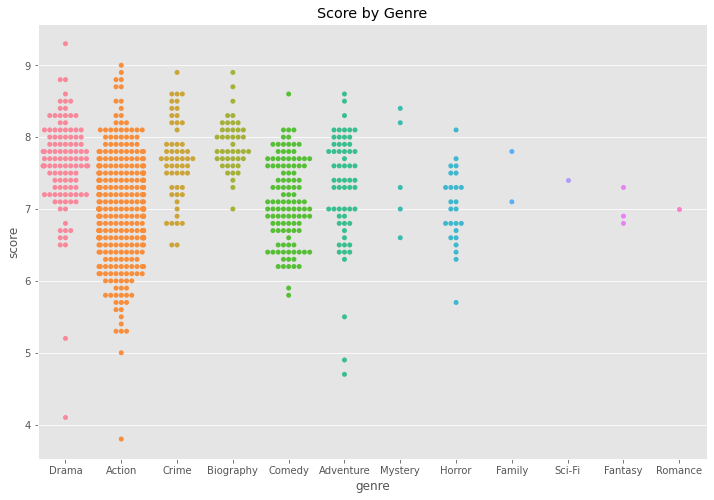

In [19]:
sns.swarmplot(x='genre', y='score', data=df).set(title='Score by Genre')

In [20]:
# Correlation matrix between numeric columns

df.corr(method='pearson')

,year,score,votes,budget,gross,runtime
year,1.000000,-0.239167,-0.108629,0.321022,0.203237,-0.006181
score,-0.239167,1.000000,0.566572,-0.307052,-0.100290,0.290762
votes,-0.108629,0.566572,1.000000,0.122878,0.324204,0.338545
budget,0.321022,-0.307052,0.122878,1.000000,0.682929,0.361498
gross,0.203237,-0.100290,0.324204,0.682929,1.000000,0.321602
runtime,-0.006181,0.290762,0.338545,0.361498,0.321602,1.000000


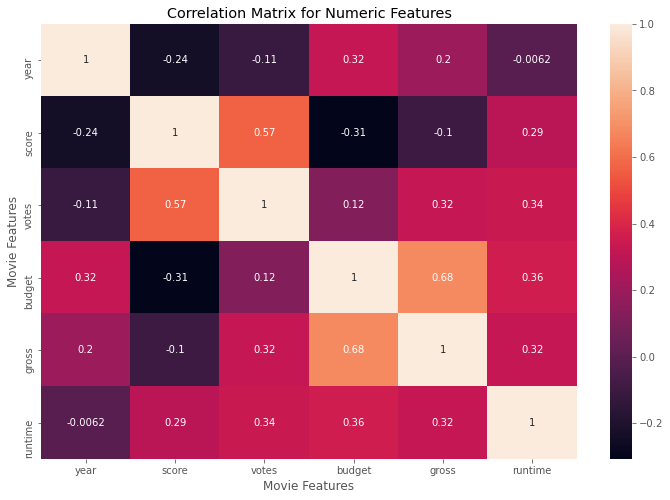

In [21]:
# Correlation heatmap for numeric features

corr = df.corr(method='pearson')

sns.heatmap(corr, annot=True)

plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

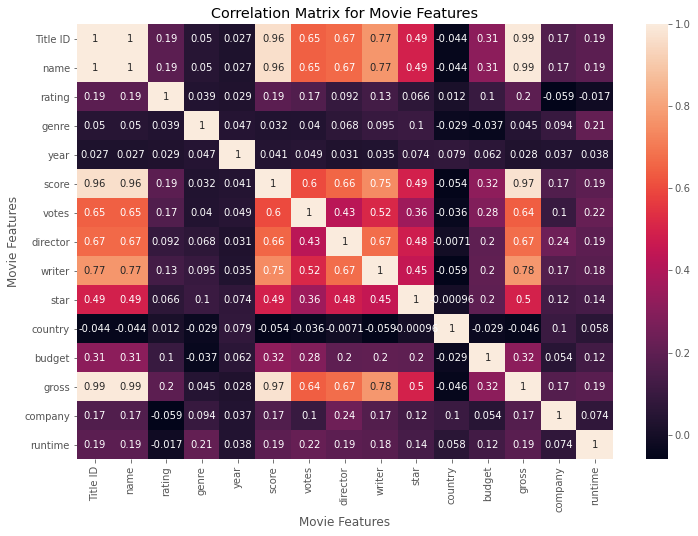

In [22]:
# Correlation heatmap for both categorical and numeric features

corr_matrix = df.apply(lambda x: x.factorize()[0]).corr(method='pearson')

sns.heatmap(corr_matrix, annot=True)

plt.title('Correlation Matrix for Movie Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

In [23]:
corr_pairs = corr_matrix.unstack().sort_values()
corr_pairs

rating    company    -0.059403
company   rating     -0.059403
writer    country    -0.058657
country   writer     -0.058657
score     country    -0.054440
                        ...   
name      name        1.000000
          Title ID    1.000000
Title ID  name        1.000000
company   company     1.000000
runtime   runtime     1.000000
Length: 225, dtype: float64

In [24]:
# Feature pairs with strong correlations

strong_pairs = corr_pairs[abs(corr_pairs > 0.75)]
strong_pairs

Title ID  writer      0.770735
name      writer      0.770735
writer    Title ID    0.770735
          name        0.770735
gross     writer      0.776385
writer    gross       0.776385
Title ID  score       0.964811
name      score       0.964811
score     Title ID    0.964811
          name        0.964811
          gross       0.971621
gross     score       0.971621
name      gross       0.993440
gross     name        0.993440
          Title ID    0.993440
Title ID  gross       0.993440
          Title ID    1.000000
director  director    1.000000
gross     gross       1.000000
budget    budget      1.000000
country   country     1.000000
star      star        1.000000
writer    writer      1.000000
votes     votes       1.000000
score     score       1.000000
year      year        1.000000
genre     genre       1.000000
rating    rating      1.000000
name      name        1.000000
          Title ID    1.000000
Title ID  name        1.000000
company   company     1.000000
runtime 

In [25]:
# Top 15 companies by gross revenue

CompanyGrossSum = df.groupby('company')[['gross']].sum()
CompanyGrossSum = CompanyGrossSum.sort_values('gross', ascending=False)[:15]
CompanyGrossSum = CompanyGrossSum['gross'].astype('int64')
CompanyGrossSum

company
Warner Bros.                 35274157604
Universal Pictures           24641203084
Twentieth Century Fox        23083820403
Paramount Pictures           20465691942
Columbia Pictures            20159664097
Walt Disney Pictures          8996977968
New Line Cinema               8719717394
Lucasfilm                     7081238708
Dreamworks Pictures           5987722151
Summit Entertainment          5965851384
Metro-Goldwyn-Mayer (MGM)     5007898599
Touchstone Pictures           3822654651
Lionsgate                     3510022224
TriStar Pictures              2179532051
Fox 2000 Pictures             1995794385
Name: gross, dtype: int64